# Presentation

L'objectif de ce notebook est de construire un exemple de modèle de prédiction du temps de course d'un athlète. Ce type de modèle, en particulier s'il est plus personnalisé, pourrait permettre à un athlète de mieux appréhender une course à laquelle il va participer.

- Input : race_result.csv and meteo.csv
- Output : modèle de prédiction du temps de course

In [4]:
VERBOSE = True

## 0. Imports

In [5]:
import sys
from pathlib import Path

# Definition du chemin vers notre code source local
sys.path.append(str(Path().resolve().parent))

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import shap

from src.definitions import CLEAN_DATA_PATH
from src.utils import find_x_closest_y, seconds_to_time

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## 1. Télécharger la donnée

In [7]:
race_results_df = pd.read_csv(CLEAN_DATA_PATH / "race_results.csv")

## 2. Pre processing

Nous allons commencer par utiliser simplement les résultats de la course de 2024.

In [8]:
# definition des features
features = ["club", "categorie", "index", "nationalite", "sexe"]
target = "temps"
data = race_results_df[features + [target]]

In [9]:
# traitement des valeurs manquantes
# Nous avons vu précédemment que les NaNs sont tous dus au fait que l'index manque ou est éronné.
# Pour ces points, nous allons utiliser l'index du temps le plus proche parmis les "index_correct"
for idx in race_results_df[race_results_df["index_correct"]==0].index:
    data.at[idx, "index"] = find_x_closest_y(
        x="index", 
        y="temps", 
        row=data.loc[idx], 
        data=race_results_df[race_results_df["index_correct"]==1],
    )

In [10]:
# train_test_split
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Définition de le pipeline
categorical_features = ["club", "categorie", "nationalite", "sexe"]
numerical_features = ["index"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numerical_features)
    ]
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42, n_estimators=100))
])

## 3. Entrainement du modèle

Comme on ne connaît pas à l'avance les lois qui lient nos fetaures à notre variable cible, nous allons utiliser un modèle d'apprentissage automatique qui ne fait pas d'hypothèse sur cette relation.

Nous prenons l'algorithme de Random Forrest car il est simple à entraînener et ses résultats sont 100% explicables.

In [12]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['club', 'categorie',
                                                   'nationalite', 'sexe']),
                                                 ('num', StandardScaler(),
                                                  ['index'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

## 4. Evaluation du modèle

In [13]:
y_pred = model.predict(X_test)

In [14]:
# métrique de base
erreur_moyenne = int(np.mean(np.abs(y_test - y_pred)))
temps = seconds_to_time(erreur_moyenne)

if VERBOSE:
    print(f"Erreur moyenne en valeur absolue = {erreur_moyenne} secondes (soit {temps[1]}min {temps[2]}s)")

Erreur moyenne en valeur absolue = 2799 secondes (soit 46min 39s)


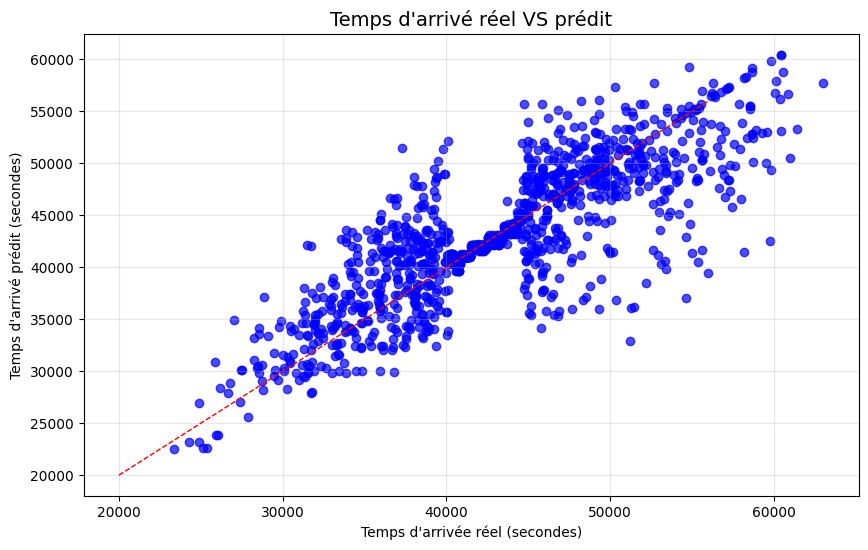

In [15]:
# plot de y_pred vs y_test
if VERBOSE:
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, color="blue", label="Prediction")
    plt.title("Temps d'arrivé réel VS prédit", fontsize=14)
    plt.xlabel("Temps d'arrivée réel (secondes)", fontsize=10)
    plt.ylabel("Temps d'arrivé prédit (secondes)", fontsize=10)
    plt.plot([20_000, 56_000], [20_000, 56_000], color="red", linestyle="--", linewidth=1, label="Erreur nulle")
    plt.grid(alpha=0.3)
    plt.show()

On voit bien que le modèle est parvenu à comprendre la relation positive.

On peut également regarder s'il y a des trends dans les erreurs.

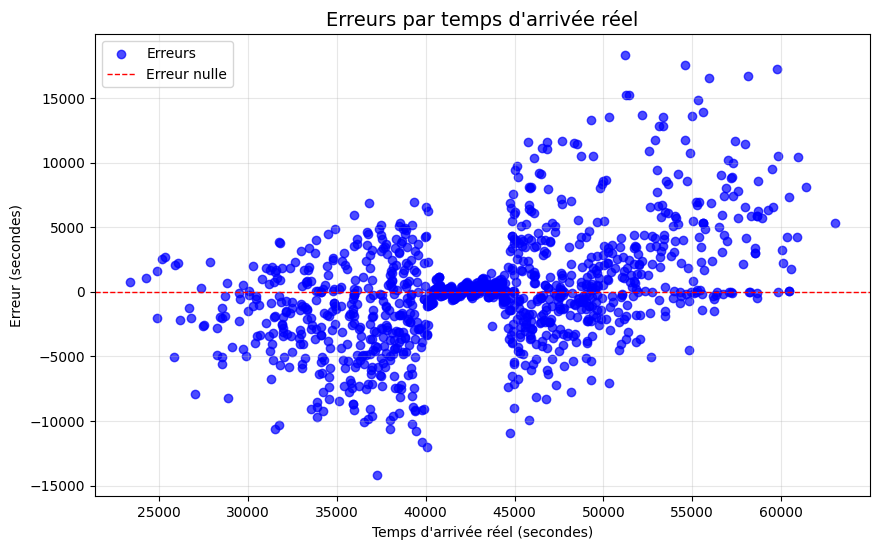

In [16]:
if VERBOSE:
    errors = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, errors, alpha=0.7, color="blue", label="Erreurs")
    plt.axhline(0, color="red", linestyle="--", linewidth=1, label="Erreur nulle")
    plt.title("Erreurs par temps d'arrivée réel", fontsize=14)
    plt.xlabel("Temps d'arrivée réel (secondes)", fontsize=10)
    plt.ylabel("Erreur (secondes)", fontsize=10)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

On voit très nettement que le modèle a tendance à sur-prédire légèrement les temps des athlètes les plus rapides, et sous-prédire le temps des athlètes les plus lents, mais la tendance n'est pas flagrante.

Il est intéressant de voir qu'entre 41000 secondes et 44000 secondes, les prédictions sont excellentes. Ceci s'explique par deux facteurs:
- La methode d'imputation fait que certains indexes de X_test sont aussi dans X_train.
- La methode d'imputation fait l'hypothèse que l'index est relié au temps d'arrivé. Les résultats sont en partie l'illustration de cette hypothèse.

## 5. Importance des paramètres dans la prédiction

Pour analyser l'importance des paramètres dans la prédiction, on utilise la librairie shap.

 98%|===================| 1225/1253 [00:16<00:00]        

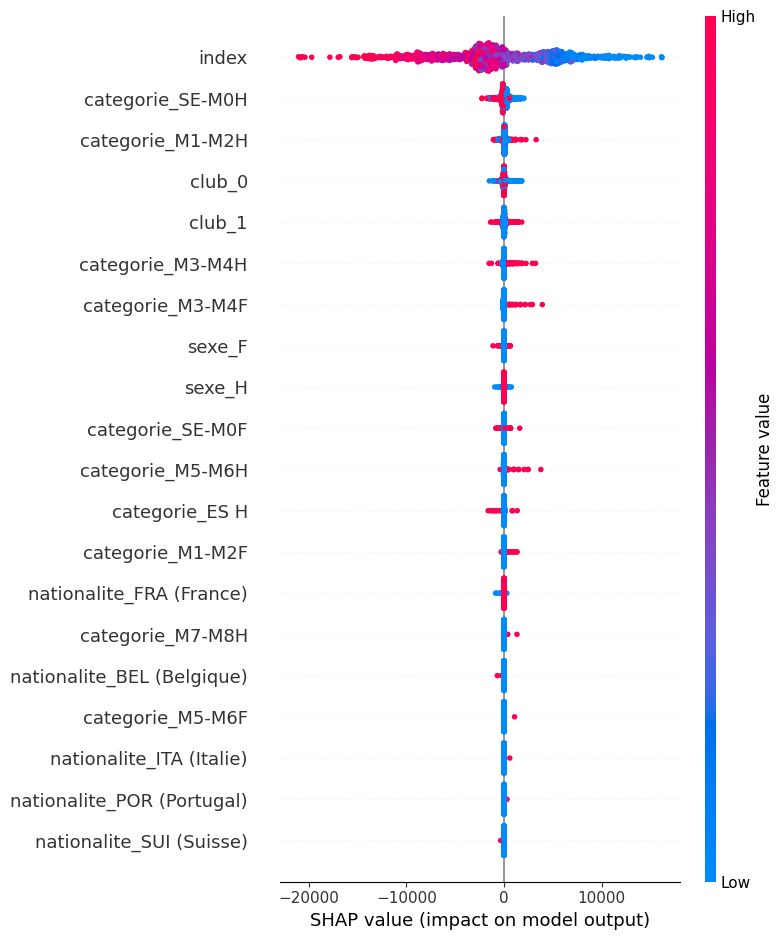

In [17]:
X_train_transformed = model.named_steps["preprocessor"].transform(X_train).toarray()
X_test_transformed = model.named_steps["preprocessor"].transform(X_test).toarray()
feature_names = (
    model.named_steps["preprocessor"]
    .transformers_[0][1]
    .get_feature_names_out(categorical_features)
    .tolist()
    + numerical_features
)

explainer = shap.Explainer(model.named_steps["regressor"], X_train_transformed, feature_names=feature_names)
shap_values = explainer(X_test_transformed, check_additivity=False)

# Visualisation des impacts globaux
if VERBOSE:
    shap.summary_plot(shap_values, features=X_test_transformed, feature_names=feature_names)


On peut voir que l'index de performance est largement le prédicteur le plus fort de la performance : plus il est haut, plus le temps de course est faible. C'est tout a fait logique car c'est l'objectif même de ce type d'index.

Il est aussi intéressant de constater que les catégories peuvent avoir un impact sur la performance. Ainsi, être SE ou M0 chez les hommes diminue le temps de course prédit alors qu'être dans toutes les autres catégories master a l'effet inverse. Chez les femmes, l'effet d'être senior n'est pas évident par contre on voit clairement que les masters sont prédis plus lents. C'est intéressant car on pourrait croire que l'index seul fait foi. Néanmoins, on peut théoriser qu'en moyenne, les athlètes plus jeunes sont en progresion alors que c'est l'inverse pour les masters. Ainsi, les "jeunes" ont tendance à avoir un niveau légèrement plus haut que leur index, alors que les athlètes plus vieux sont sur la courbe inverse.

Autre résultat interessant : Ne pas être français réduit le temps prédit. Une explication potentielle serait que les athlètes étrangers venant faire la course la prenne plus au sérieux en moyenne puisqu'ils viennent de loin. C'était donc potentiellement d'avantage une "course objectif" pour eux que pour les français.

Enfin, on peut voir que le sexe a peu d'impact sur la prédiction. Ce résultat me semble logique puisque l'index de performance est non-genré, et contient donc indirectement cette information (ie en moyenne les femmes ont des indexes plus faibles que les hommes).

## 6. Impact de la meteo

Je n'ai pas intégré la météo directement au modèle car nous n'avions que les donnée de course d'une année. Ainsi, la météo était la même pour tous les coureurs. Néanmoins, nous avons à notre disposition les données de météo sur 4 année avec les résultats du premier et du dixième coureur sur ces années.

La course n'emprunte pas toujours exactement le même parcours, ainsi nous allons aussi corriger ces temps avec ces données. Comme nous avons peu de données, nous allons fabriquer une méthode à la main grace à notre connaissance du trail. Le but est d'obtenir des facteurs de variation du résultat en fonction de la météo. Pour cela nous allons:
1. Calculer une distance équivalente qui vaut : distance_réelle + dénivelé / 100
2. Ramener les temps à un kilomètre équivalent
3. Corriger l'évolution naturelle des temps du à l'amélioration générale du niveau, du matériel et de la densité (pour le temps du 10ème uniquement)
4. Transformer l'objectif en % de variation du temps de le trend
5. Calculer les coefficients de corrélation entre le temps équivalent et la météo

In [18]:
meteo_df = pd.read_csv(CLEAN_DATA_PATH / "meteo.csv")

In [19]:
# Etape 1
meteo_df["distance_eq"] = meteo_df["distance_course"] + meteo_df["denivele_course"] / 100
meteo_df["temps_vainqueur_eq"] = meteo_df["temps_vainqueur"] / meteo_df["distance_eq"]

# Etape 2 
meteo_df["temps_dixieme_eq"] = meteo_df["temps_dixieme"] / meteo_df["distance_eq"]

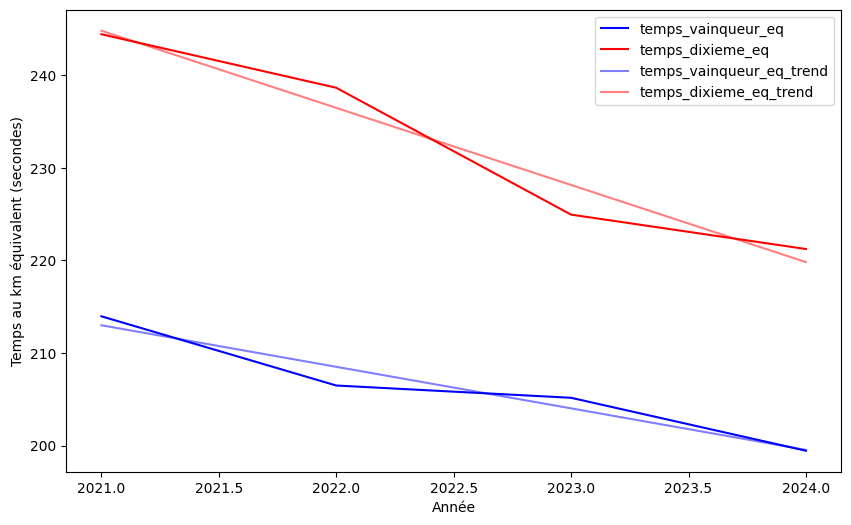

In [20]:
# Etape 3

model_trend_vainqueur = LinearRegression()
model_trend_vainqueur.fit(meteo_df[["annee"]], meteo_df["temps_vainqueur_eq"])
meteo_df["temps_vainqueur_eq_trend"] = model_trend_vainqueur.predict(meteo_df[["annee"]])
meteo_df["temps_vainqueur_eq_detrend"] = meteo_df["temps_vainqueur_eq"] - meteo_df["temps_vainqueur_eq_trend"]

model_trend_dixieme = LinearRegression()
model_trend_dixieme.fit(meteo_df[["annee"]], meteo_df["temps_dixieme_eq"])
meteo_df["temps_dixieme_eq_trend"] = model_trend_dixieme.predict(meteo_df[["annee"]])
meteo_df["temps_dixieme_eq_detrend"] = meteo_df["temps_dixieme_eq"] - meteo_df["temps_dixieme_eq_trend"]

if VERBOSE:
    plt.figure(figsize=(10, 6))
    plt.plot(meteo_df["annee"], meteo_df["temps_vainqueur_eq"], color="blue", label="temps_vainqueur_eq")
    plt.plot(meteo_df["annee"], meteo_df["temps_dixieme_eq"], color="red", label="temps_dixieme_eq")
    plt.plot(meteo_df["annee"], meteo_df["temps_vainqueur_eq_trend"], alpha=0.5, color="blue", label="temps_vainqueur_eq_trend")
    plt.plot(meteo_df["annee"], meteo_df["temps_dixieme_eq_trend"], alpha=0.5, color="red", label="temps_dixieme_eq_trend")
    plt.xlabel("Année")
    plt.ylabel("Temps au km équivalent (secondes)")
    plt.legend()
    plt.show()

In [21]:
# Etape 4
meteo_df["performance_multiplicator_vainqueur"] = meteo_df["temps_vainqueur_eq_detrend"] / meteo_df["temps_vainqueur_eq_trend"]
meteo_df["performance_multiplicator_dixieme"] = meteo_df["temps_dixieme_eq_detrend"] / meteo_df["temps_dixieme_eq_trend"]

In [22]:
# Etape 5

X = meteo_df[["temperature", "ressenti", "verglas_neige_abondante"]]
y = meteo_df["performance_multiplicator_vainqueur"]
model_vainqueur = LinearRegression()
model_vainqueur.fit(X, y)

X = meteo_df[["temperature", "ressenti", "verglas_neige_abondante"]]
y = meteo_df["performance_multiplicator_dixieme"]
model_dixieme = LinearRegression()
model_dixieme.fit(X, y)

coefficients = pd.DataFrame({
    'Feature': ['temperature', 'ressenti', 'verglas_neige_abondante'],
    'Coefficient_vainqueur': model_vainqueur.coef_,
    'Coefficient_dixieme': model_dixieme.coef_
})

if VERBOSE:
    display(coefficients)

,Feature,Coefficient_vainqueur,Coefficient_dixieme
0,temperature,0.001763,-0.003746
1,ressenti,-0.004181,0.004550
2,verglas_neige_abondante,-0.004549,-0.009675


Les résultats ne sont pas très probants, et une étude statistique rapide peut montrer qu'ils ne sont pas signifatifs. Il faudrait d'avantage de points de donnée pour obtenir des résultats significatifs.

Néanmoins cette étude a permit de mettre en lumière l'impact du temps sur les résultats. En effet le trail est un sport en plein essort et les chronos baissent d'année en année. On peut donc considérer que pour prédire correctement de futures performances, il faut intégrer un effet d'amélioration naturelle.

Sur la Sainté Lyon, d'après notre modèle, pour la course de 2025 il faudra appliquer un coefficient multiplicatif de :

In [23]:
correctif_2025 = model_trend_vainqueur.coef_[0] / meteo_df[meteo_df["annee"]==2024]["temps_vainqueur_eq_trend"].to_numpy()[0]
if VERBOSE:
    print(correctif_2025)

-0.022490231632093426


## 7. Exemple d'utilisation du modèle

Mathieu Blanchard souhaite s'alligner sur la Sainté Lyon 2025. Le parcours est le même qu'en 2024. Il demande a Enduraw de l'aider à anticiper la longueur de sa course car il ne la connait pas et a moins d'expérience sur ce genre de format (on pourrait imaginer faire la même chose pour les temps de passage intermédiaire).

In [24]:
# Predicition de son temps brute
X_mb = pd.DataFrame(
    {
        "club": [1],
        "categorie": ["categorie_SE-M0H"],
        "index": [925],
        "nationalite": ["nationalite_FRA (France)"],
        "sexe": ["H"]
    }
)
y_mb = int(model.predict(X_mb)[0])
temps_mb = seconds_to_time(y_mb)

if VERBOSE:
    print(f"Sans correction annuelle, le temps prédit est de {temps_mb[0]}h {temps_mb[1]}min {temps_mb[2]}s")

Sans correction annuelle, le temps prédit est de 6h 8min 2s


In [25]:
# Correction de l'année
y_annulisé_mb = int(y_mb * (1 + correctif_2025))
temps_annualisé_mb = seconds_to_time(y_annulisé_mb)

if VERBOSE:
    print(f"Sans correction annuelle, le temps prédit est de {temps_annualisé_mb[0]}h {temps_annualisé_mb[1]}min {temps_annualisé_mb[2]}s")

Sans correction annuelle, le temps prédit est de 5h 59min 45s


Le temps final de Mathieu prédit par notre modèle est de 5h 59min 45s. C'est sans doute un temps légèrement trop long car, comme on a pu le voir, le modèle prédit des temps légèrement trop long (de l'ordre de 10 minutes) pour les athlètes du top de la course.

# END OF NOTEBOOK